In [10]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy.linalg as LA
import random

# Probablistic Roadmap (PRM)

### Define Node Class
* variables : position, edge, f, g, parent(previous node)
* methods : 
    * \- (sub) : calculate euclidean distance
    * \= (equal) : same node position
    * < (less than) : compare node cost for sorting
    * repr : print node information
    * show : visualize node position

In [18]:
class Node():
    def __init__(self, position, edge=[]):
        self.position = np.array(position)
        self.edge = edge
        self.f = np.inf
        self.g = 0
        self.parent = None
        
    def __sub__(self, other):
        return LA.norm(self.position-other.position)
    
    def __repr__(self):
        return 'pos:{0}, f:{1}, edge_num:{2}'.format(self.position, self.f, len(self.edge))
    
    def __eq__(self, other):
        return np.array_equal(self.position, other.position)
    
    def __lt__(self,other):
        return self.f < other.f
    
    def show(self, **kwargs):
        plt.gca().scatter(self.position[0], self.position[1], **kwargs)
        plt.xlim([0,10])
        plt.ylim([0,10])

### Define PRM Algorithm Class
* variables : 
    * smpl_area : map area for RRT
    * obstacles : circular obstacles informations
* methods : 
    * get_rnd_smpls : select random points in smpl_area
    * is_goal : goal node detection using euclidean distance
    * node_is_collision : node collision detection using euclidean distance
    * edge_is_collision : edge collision detection calculated by dividing two points by 10
    * node_get_neighbors : Search neighbor node by distance
    * is_in_area : check if node is in area
    * find_nearest_node : find nearest node in tree
    * fine_neighbor_nodes : find neighbor node of new_node by distance

In [98]:
class PRMAlg():
    nodes = []
    
    def __init__(self, start, end, smpl_area, obstacles):
        self.start = start
        self.end = end
        self.smpl_area = smpl_area
        self.obstacles = obstacles
    
    def get_rnd_smpls(self, num):
        output = []
        area = self.smpl_area
        while len(output) < num:
            pos = np.array((random.uniform(*area[0:2]), random.uniform(*area[2:4])))
            if not self.node_is_collision(pos):
                output.append(pos)
        return np.array(output)
            
    def edge_is_collision(self, pos1, pos2):
        step = (pos2-pos1)/10
        points = [pos1 + step*i for i in np.arange(11)]
        for pt in points:
            for obs in self.obstacles:
                obs_pos = np.array(obs[0:2])
                obs_radius = obs[2]
                if LA.norm(pt - obs_pos) <= obs_radius:
                    return True
        return False
    def node_is_collision(self, pos):
        for obs in self.obstacles:
            obs_pos = np.array(obs[0:2])
            obs_radius = obs[2]
            if LA.norm(pos - obs_pos) <= obs_radius:
                return True
        return False
    
    def node_get_neighbors(self, node, distance):
        nbrs = []
        for node_ in self.nodes:
            if (node_-node < distance) & (node_!=node):
                nbrs.append(node_)
        return nbrs
    
    def is_goal(self, node, margin=0.5):
        if node-self.end < margin:
            return True
        return False


In [191]:
class AstarAlg():
    open_list = []
    closed_list = []
    
    def __init__(self, start=None, end=None):
        self.start = start
        self.end = end
    
    def get_neighbor_node(self, curr_node):
        return curr_node.edge
        
    def is_goal(self, node):
        return node == self.end
    
    def calc_cost(self, node):
        #calc cost
        if type(node.parent) == type(None):
            node.g = 1
        else:
            node.g = node.parent.g + 1            # the cost of the cheapest path from start
        node.h = self.end - node              # heuristic : manhattan distance
        node.f = node.g + node.h    # best guess
        return node
    
    def is_update_condition(self, node):
        """
        if node is in open list and cost is higher, update (delete and add).
        if node is in open list and cost is lower, pass.
        if node is not in open list, add
        
        """
        for temp_node in self.open_list:
            if (temp_node == node):
                if (temp_node.f > node.f):
                    del(temp_node) #update : delete and add
                    return True
                else:
                    return False
        return True
                


## PRM Class : PRM Algorithm(Graph) + A*(Search) + Visualization

In [192]:
class PRM(PRMAlg, AstarAlg):
    def __init__(self, start, end, smpl_area, obstacles):
        PRMAlg.__init__(self, start, end, smpl_area, obstacles)
        
    
    def plot_graph(self):
        ax = plt.gca()
        visited = []
        for node in self.nodes:
            visited.append(node)
            for edge in node.edge:
                if not edge in visited:
                    pts = np.array([node.position, edge.position])
                    plt.plot(*pts.T,'k', alpha=0.2)
        nodes_pos = np.array([node.position.tolist() for node in self.nodes])
        plt.scatter(*nodes_pos.T)
        
    def plot_lim(self):
        ax = plt.gca()
        ax.set_xlim(smpl_area[0:2])
        ax.set_ylim(smpl_area[2:4])
    
        
    def plot_obstacles(self):
        ax = plt.gca()
        circles = [mpatches.Circle(obs[:2], obs[2], color='k') for obs in self.obstacles]
        for c in circles:
            ax.add_artist(c)
        self.plot_lim()

### Initialization

In [193]:
start_node = Node([5,5])
end_node = Node([1,1])
smpl_area = [0, 10, 0, 10]
obstacles = [(4,8,1), (6,4,1), (3,3,1)]
prm = PRM(start_node, end_node, smpl_area, obstacles)

## Graph : Probabilistic roadmap

In [194]:
# link edge if there is not collision
rnd_smpls_pos = prm.get_rnd_smpls(200)
prm.nodes = [Node(pos) for pos in rnd_smpls_pos]
prm.nodes.append(start_node)
prm.nodes.append(end_node)

for node in prm.nodes:
    nbrs = prm.node_get_neighbors(node, 2)
    edge_ = []
    for nbr in nbrs:
        if not prm.edge_is_collision(node.position, nbr.position):
            edge_.append(nbr)
    node.edge = edge_

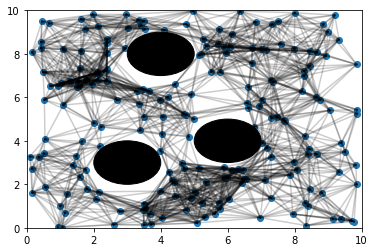

In [188]:
#visualization
prm.plot_graph()
prm.plot_obstacles()

## Search Graph : A*

### Initialization

In [195]:
for node in prm.nodes:
    node.f = np.inf
    node.g = 0
    node.parent=None

prm.open_list = [prm.start]
prm.closed_list = []
print('start:',prm.start.position)
print('end:',prm.end.position)

start: [5 5]
end: [1 1]


In [196]:
while prm.open_list:
    prm.open_list.sort()
    curr = prm.open_list.pop(0)
    prm.closed_list.append(curr)
    
    if prm.is_goal(curr):
        print('goal')
        prm.end = curr #curr has parent information
        break
    
    nbrs = prm.get_neighbor_node(curr)
    
    for nbr in nbrs:
        if nbr in prm.closed_list:
            continue
        prm.calc_cost(nbr)

        if prm.is_update_condition(nbr):
            nbr.parent = curr
            prm.open_list.append(nbr)
            

goal


### Reconstruct Path

* Result : 
  goal - goal.parent - goal.parent.parent - ...

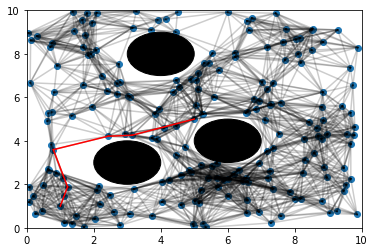

In [207]:
f, ax = plt.subplots()
prm.plot_graph()
prm.plot_obstacles()

# reconstruct path
temp = prm.end
while temp.parent:
    pts = np.array([temp.position, temp.parent.position])
    ax.plot(*pts.T, color='r')
    temp = temp.parent